In [1]:
import torch as th
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
import sys
sys.path.insert(0, '../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

# from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
# cfg.img_cond_model.in_image = cfg.img_cond_model.in_image
# cfg.img_cond_model.prep_image = [None, 'dilate=5', None]
cfg.img_model.image_size = 256
# Load dataset
dataset = 'ffhq'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
# Load dataset
if dataset == 'itw':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset in ['mp_valid', 'mp_test', 'mp_test2']:
    if dataset == 'mp_test':
        sub_f = '/MultiPIE_testset/'
    elif dataset == 'mp_test2':
        sub_f = '/MultiPIE_testset2/'
    elif dataset == 'mp_valid':
        sub_f = '/MultiPIE_validset/'
    else: raise ValueError
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/params/"
    img_ext = '.png'
    cfg.dataset.training_data = f'/MultiPIE/{sub_f}/'
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise ValueError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

from importlib import reload
sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = True 
deca = DECA(config = deca_cfg, device='cuda', mode='shape', mask=mask)

print(deca)

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path])
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
os.makedirs('./output', exist_ok=True)
import tqdm
# for _ in tqdm.tqdm(range(len(img_path))):
subset_loader = iter(subset_loader)
t = tqdm.trange(len(subset_loader), desc="Generate the shadow mask...")
for _ in t:
    _, model_kwargs = next(subset_loader)

[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml')



Loading deca params...: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
DECA(
  (E_flame): ResnetEncoder(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momen

Generate the shadow mask...: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


[#] Dict's keys :  dict_keys(['deca_masked_face_images_woclip_img', 'faceseg_nohead_img', 'faceseg_nohead_mask', 'cond_params', 'shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'tform', 'albedo', 'detail', 'shadow', 'image_name', 'raw_image', 'raw_image_path', 'image'])
[#] Light :  torch.Size([1, 9, 3])


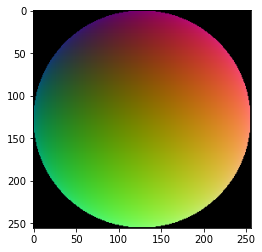

torch.Size([1, 256, 256, 3])
[#] Shading :  torch.Size([1, 3, 256, 256])
tensor(0.85236, dtype=torch.float64) tensor(1.71463, dtype=torch.float64)


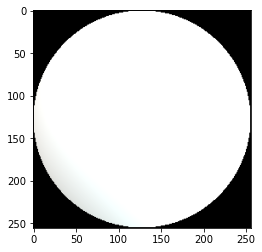

In [3]:
import cv2

def add_SHlight(normal_images, sh_coeff):
    '''
        sh_coeff: [bz, 9, 3]
        normal_images: [bz, 3, 256, 256]
    '''
    pi = np.pi
    constant_factor = th.tensor([1/np.sqrt(4*pi), ((2*pi)/3)*(np.sqrt(3/(4*pi))), ((2*pi)/3)*(np.sqrt(3/(4*pi))),\
                        ((2*pi)/3)*(np.sqrt(3/(4*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))),\
                        (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))]).float()
    N = normal_images
    sh = th.stack([
            N[:,0]*0.+1., N[:,0], N[:,1], \
            N[:,2], N[:,0]*N[:,1], N[:,0]*N[:,2], 
            N[:,1]*N[:,2], N[:,0]**2 - N[:,1]**2, 3*(N[:,2]**2) - 1
            ], 
            1) # [bz, 9, h, w]
    sh = sh*constant_factor[None,:,None,None]
    shading = th.sum(sh_coeff[:,:,:,None,None]*sh[:,:,None,:,:], 1) # [bz, 9, 3, h, w]  
    return shading

def gen_normal(img_size=256):
    x = np.linspace(-1, 1, img_size)
    y = np.linspace(-1, 1, img_size)
    x, y = np.meshgrid(x, y)

    mag = np.sqrt(x**2 + y**2)
    valid = mag <=1
    z = -np.sqrt(1 - (x*valid)**2 - (y*valid)**2)
    nx = x * valid
    ny = y * valid
    nz = z * valid
    # normal = np.stack((x, z, y), axis=2)    # Forming x, y, z to Normal maps
    
    normal = np.zeros((img_size, img_size, 3))
    normal[:, :, 0] = (nx + 1) / 2
    normal[:, :, 1] = (ny + 1) / 2
    normal[:, :, 2] = (nz + 1) / 2
    
    plt.imshow(((normal * valid[..., None])*255).astype(np.uint8))
    plt.show()
    # norm = np.sqrt(np.sum(normal**2, axis=-1))
    # plt.imshow(np.stack([norm]*3, axis=-1))
    # plt.show()
    return normal, valid[..., None]

print("[#] Dict's keys : ", model_kwargs.keys())

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path])
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['61053.jpg'])

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
os.makedirs('./output', exist_ok=True)
import tqdm
# for _ in tqdm.tqdm(range(len(img_path))):
_, model_kwargs = next(iter(subset_loader))

## SH factors for lighting
light = model_kwargs['light']
light = light.reshape(-1, 9, 3)
print("[#] Light : ", light.shape)
normal, valid = gen_normal()
normal = th.tensor(normal[None, ...])
print(normal.shape)
shading_con = add_SHlight(normal_images=normal.permute(0, 3, 1, 2), sh_coeff=light)
print("[#] Shading : ", shading_con.shape)
print(th.min(shading_con), th.max(shading_con))
shading_con = shading_con * th.tensor(valid).permute(2, 0, 1) * 255.0
shading_vis = shading_con.permute(0, 2, 3, 1).cpu().numpy()[0]
shading_vis = np.clip(shading_vis, 0, 255)
plt.imshow(shading_vis.astype(np.uint8))
plt.show()


In [ ]:
import numpy as np
from PIL import Image

# Define the image size
img_width, img_height = 256, 256

# Define the chrome ball radius
r = 1.0

# Generate a 2D grid of points corresponding to each pixel in the output normal map image
x, y = np.meshgrid(np.linspace(-1, 1, img_width), np.linspace(-1, 1, img_height))
z = np.sqrt(1 - x**2 - y**2)

# Map the 2D grid points onto the surface of a unit sphere
x_sphere = x / np.sqrt(x**2 + y**2 + z**2)
y_sphere = y / np.sqrt(x**2 + y**2 + z**2)
z_sphere = z / np.sqrt(x**2 + y**2 + z**2)

# Calculate the normal vector at each point on the surface of the chrome ball

nx = -x_sphere / np.sqrt(x_sphere**2 + y_sphere**2)
ny = -y_sphere / np.sqrt(x_sphere**2 + y_sphere**2)
nz = -z_sphere / np.sqrt(x_sphere**2 + y_sphere**2)

# Convert the normal vectors to RGB colors that can be used to create the normal map
normal_map = np.zeros((img_height, img_width, 3))
normal_map[:, :, 0] = (nx + 1) / 2
normal_map[:, :, 1] = (ny + 1) / 2
normal_map[:, :, 2] = (nz + 1) / 2

# Convert the RGB colors to a PIL image and save it to disk
normal_map_image = Image.fromarray((normal_map * 255).astype(np.uint8))
normal_map_image.save('chrome_ball_normal_map.png')

[#] Dict's keys :  dict_keys(['deca_masked_face_images_woclip_img', 'faceseg_nohead_img', 'faceseg_nohead_mask', 'cond_params', 'shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'tform', 'albedo', 'detail', 'shadow', 'image_name', 'raw_image', 'raw_image_path', 'image'])
[#] Light :  torch.Size([1, 9, 3])
1.10.1
torch.Size([9, 3])
(100, 100) [0.55198336 0.55198336 0.55200429 ... 1.30956266 1.30956509 1.30963447]


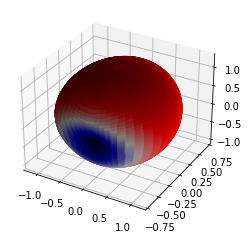

In [65]:
import scipy

print("[#] Dict's keys : ", model_kwargs.keys())

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path])
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
os.makedirs('./output', exist_ok=True)
import tqdm
# for _ in tqdm.tqdm(range(len(img_path))):
_, model_kwargs = next(iter(subset_loader))

## SH factors for lighting
light = model_kwargs['light']
light = light.reshape(-1, 9, 3)
print("[#] Light : ", light.shape)

print(scipy.__version__)
# out = scipy.special.sph_harm(m=[-2, -1, 0, 1, 2], n=[0, 1, 2], theta=np.arange(0, 2*np.pi), phi=np.arange(0, np.pi))
num = 10
l = 2

# Define spherical harmonic coefficients
coeffs = light[0]

# Define azimuthal and polar angles
phi, theta = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100))

# Evaluate spherical harmonic
print(coeffs.shape)
sh_values = np.zeros_like(phi, dtype=np.complex128)
for l in range(coeffs.shape[1]):
    for m in range(-l, l+1):
        # sh_values += coeffs[l, m] * scipy.special.sph_harm(m, l, phi, theta)
        if l < 0:
            l_abs = -l
            sign = (-1)**l_abs
        else:
            l_abs = l
            sign = 1
        sh_values = sh_values + (coeffs[l_abs, m].cpu().numpy() * scipy.special.sph_harm(m, l_abs, phi, theta) * sign)

# Convert to real values
sh_values = np.real(sh_values)
print(sh_values.shape, np.unique(sh_values))

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


# Make data.
r = sh_values
X = r * np.sin(theta) * np.cos(phi)
Y = r * np.sin(theta) * np.sin(phi)
# Z = np.sqrt(X**2 + Y**2)
Z = r * np.cos(theta)
# Z = np.sin(R)

fcolors = sh_values
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Plot the surface.
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=cm.seismic(fcolors))
plt.show()



tensor([[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
(100, 100, 3) 0.0 1.0
(100, 100, 3) 0.0 1.0


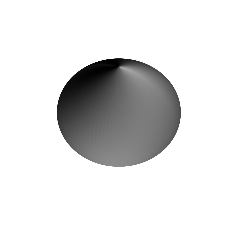

In [100]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

sh_values = np.zeros(shape=(phi.shape[0], phi.shape[1], 3), dtype=np.complex128)
# m, l = 2, 3
coeffs *= 0
# coeffs[0:1, :] = coeffs[0:1, :] + 1
coeffs[1:2, :] = coeffs[1:2, :] + 1
# coeffs[2:3, :] = coeffs[2:3, :] + 1
# coeffs[3:4, :] = coeffs[3:4, :] + 1
print(coeffs)
# coeffs shape : 9 x 3
for c in range(coeffs.shape[1]):    # Each color channels
    for li in range(coeffs.shape[0]):
        for mi in range(0, li+1):
            sh_values[..., c] = sh_values[..., c] + (coeffs[li, c].cpu().numpy() * scipy.special.sph_harm(mi, li, phi, theta))

# Convert to real values
sh_values = np.real(sh_values)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)


# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
# fcolors = sph_harm(m, l, theta, phi).real
fcolors = sh_values
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)
# print(sh_values.shape, np.max(sh_values), np.min(sh_values))
print(fcolors.shape, np.min(fcolors), np.max(fcolors))
# fcolors = np.concatenate((fcolors, np.zeros((fcolors.shape[0], fcolors.shape[1], 1))), axis=-1)
print(fcolors.shape, np.min(fcolors), np.max(fcolors))

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=fcolors)
# Turn off the axis planes
ax.set_axis_off()
plt.show()